In [1]:
import os
from pathlib import Path
while Path.cwd().name != 'bayesian_beats_cheats':
    os.chdir(Path.cwd().parent)

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import random
import math

In [38]:
df = pd.read_csv('data/unified_node_data.csv', keep_default_na=False)
df.sort_values('num_confessed_assignments', ascending=True, inplace=True)

name2confession = dict(df[['name', 'confessed_assignments']].values)

known_true = set(df.loc[df['num_confessed_assignments'] > 0, 'name'])
print('num nodes:           ', len(df))
print('num known true nodes:', len(known_true))
print('true/total:          ', len(known_true)/len(df))

num nodes:            1256
num known true nodes: 160
true/total:           0.12738853503184713


In [4]:
# tgt_cols = ['mission', 'name1', 'cohort1', 'name2', 'cohort2', 'percent1', 'percent2', 'lines', 'rank']

individual_moss = ['raw_data/1821.csv', 'raw_data/1935.csv', 'raw_data/2023.csv']
pairwise_moss = ['raw_data/1821_1935.csv', 'raw_data/1821_2023.csv', 'raw_data/1935_2023.csv']
triplet_moss = ['raw_data/1821_1935_2023.csv']

In [5]:
for fn_set, type in [(individual_moss, 'individual'), (pairwise_moss, 'pairwise'), (triplet_moss, 'triplet')]:
    flagged_by_moss = set()
    for fn in fn_set:
        df_moss = pd.read_csv(fn)
        mask = df_moss['name1'] != df_moss['name2']
        df_moss = df_moss[mask]
        flagged_by_moss = flagged_by_moss.union(df_moss['name1'])
        flagged_by_moss = flagged_by_moss.union(df_moss['name2'])
    print(f'=== {type} cohort stats ===')
    print('num nodes captured in moss:            ', len(flagged_by_moss))
    print('num known true nodes found in moss:    ', len(known_true & flagged_by_moss))
    print('num known true nodes missing from moss:', len(known_true - flagged_by_moss))
    print()

=== individual cohort stats ===
num nodes captured in moss:             1164
num known true nodes found in moss:     160
num known true nodes missing from moss: 0

=== pairwise cohort stats ===
num nodes captured in moss:             1143
num known true nodes found in moss:     157
num known true nodes missing from moss: 3

=== triplet cohort stats ===
num nodes captured in moss:             1030
num known true nodes found in moss:     147
num known true nodes missing from moss: 13



In [6]:
def get_rank_weight(df):
    groupby_mission = df.groupby('mission')
    df['max_rank'] = groupby_mission['rank'].transform('count')
    df['weight_rank'] = math.e**-(df['rank']/df['max_rank'])
    return df

def get_line_weight(df):
    df['weight_lines'] = 1 - np.exp(-df['lines']/10)
    return df

def get_percent_weights(df):
    df['weight_percent_max'] = df[['percent1', 'percent2']].max(axis='columns')/100
    df['weight_percent_min'] = df[['percent1', 'percent2']].min(axis='columns')/100
    df['weight_percent_mean'] = df[['percent1', 'percent2']].mean(axis='columns')/100
    groupby_mission = df.groupby('mission')
    max_mean  = groupby_mission['weight_percent_max'].mean()
    max_std   = groupby_mission['weight_percent_max'].std()
    min_mean  = groupby_mission['weight_percent_min'].mean()
    min_std   = groupby_mission['weight_percent_min'].std()
    mean_mean = groupby_mission['weight_percent_mean'].mean()
    mean_std  = groupby_mission['weight_percent_mean'].std()
    df['weight_percent_max_norm']  = df.apply(lambda r: (r['weight_percent_max'] - max_mean[r['mission']]) / max_std[r['mission']], axis="columns")
    df['weight_percent_min_norm']  = df.apply(lambda r: (r['weight_percent_min'] - min_mean[r['mission']]) / min_std[r['mission']], axis="columns")
    df['weight_percent_mean_norm'] = df.apply(lambda r: (r['weight_percent_mean'] - mean_mean[r['mission']]) / mean_std[r['mission']], axis="columns")
    max_mission_weights  = (1 - max_mean).to_dict()
    min_mission_weights  = (1 - min_mean).to_dict()
    mean_mission_weights = (1 - mean_mean).to_dict()
    df['weight_percent_max_weighted_mean']  = df.apply(lambda r: r['weight_percent_max'] * max_mission_weights[r['mission']], axis="columns")
    df['weight_percent_min_weighted_mean']  = df.apply(lambda r: r['weight_percent_min'] * min_mission_weights[r['mission']], axis="columns")
    df['weight_percent_mean_weighted_mean'] = df.apply(lambda r: r['weight_percent_mean'] * mean_mission_weights[r['mission']], axis="columns")
    df['weight_percent_max_norm_weighted_mean']  = df.apply(lambda r: r['weight_percent_max_norm'] * max_mission_weights[r['mission']], axis="columns")
    df['weight_percent_min_norm_weighted_mean']  = df.apply(lambda r: r['weight_percent_min_norm'] * min_mission_weights[r['mission']], axis="columns")
    df['weight_percent_mean_norm_weighted_mean'] = df.apply(lambda r: r['weight_percent_mean_norm'] * mean_mission_weights[r['mission']], axis="columns")

    
    max_mission_weights  = max_std.to_dict()
    min_mission_weights  = min_std.to_dict()
    mean_mission_weights = mean_std.to_dict()
    df['weight_percent_max_weighted_std']  = df.apply(lambda r: r['weight_percent_max'] * max_mission_weights[r['mission']], axis="columns")
    df['weight_percent_min_weighted_std']  = df.apply(lambda r: r['weight_percent_min'] * min_mission_weights[r['mission']], axis="columns")
    df['weight_percent_mean_weighted_std'] = df.apply(lambda r: r['weight_percent_mean'] * mean_mission_weights[r['mission']], axis="columns")
    df['weight_percent_max_norm_weighted_std']  = df.apply(lambda r: r['weight_percent_max_norm'] * max_mission_weights[r['mission']], axis="columns")
    df['weight_percent_min_norm_weighted_std']  = df.apply(lambda r: r['weight_percent_min_norm'] * min_mission_weights[r['mission']], axis="columns")
    df['weight_percent_mean_norm_weighted_std'] = df.apply(lambda r: r['weight_percent_mean_norm'] * mean_mission_weights[r['mission']], axis="columns")
    return df

def get_percent_weights(df):
    df['weight_percent_max'] = df[['percent1', 'percent2']].max(axis='columns')/100
    df['weight_percent_min'] = df[['percent1', 'percent2']].min(axis='columns')/100
    df['weight_percent_mean'] = df[['percent1', 'percent2']].mean(axis='columns')/100

    groupby_mission = df.groupby('mission')
    for agg in ['max', 'min', 'mean']:
        df[f'{agg}_mean']  = groupby_mission[f'weight_percent_{agg}'].transform('mean')
        df[f'{agg}_std']   = groupby_mission[f'weight_percent_{agg}'].transform('std')
        df[f'weight_percent_{agg}_norm']  = (df[f'weight_percent_{agg}'] - df[f'{agg}_mean']) / df[f'{agg}_std']

        df[f'weight_percent_{agg}_weighted_mean']       = df[f'weight_percent_{agg}'] * (1 - df[f'{agg}_mean'])
        df[f'weight_percent_{agg}_norm_weighted_mean']  = df[f'weight_percent_{agg}_norm'] * (1 - df[f'{agg}_mean'])

        df[f'weight_percent_{agg}_weighted_std']        = df[f'weight_percent_{agg}'] *df[f'{agg}_std']
        df[f'weight_percent_{agg}_norm_weighted_std']   = df[f'weight_percent_{agg}_norm'] * df[f'{agg}_std']
    return df

def get_combined_weights(df):
    for flavour in ['', '_norm']:
        for agg in ['max', 'min', 'mean']:
            base = f'weight_percent_{agg}{flavour}'
            df[f'{base}_rank']       = df[f'{base}'] * df['weight_rank']
            df[f'{base}_lines']      = df[f'{base}'] * df['weight_lines']
            df[f'{base}_rank_lines'] = df[f'{base}_rank'] * df['weight_lines']
            for weight_type in ['mean', 'std']:
                df[f'{base}_weighted_{weight_type}_rank']       = df[f'{base}_weighted_{weight_type}'] * df['weight_rank']
                df[f'{base}_weighted_{weight_type}_lines']      = df[f'{base}_weighted_{weight_type}'] * df['weight_lines']
                df[f'{base}_weighted_{weight_type}_rank_lines'] = df[f'{base}_weighted_{weight_type}_rank'] * df['weight_lines']
    return df

In [7]:
%%time
df_moss = []
for fn in pairwise_moss:
    _df_moss = pd.read_csv(fn)
    mask = _df_moss['name1'] != _df_moss['name2']
    _df_moss = _df_moss[mask]
    _df_moss['rank'] = _df_moss['url'].str.rsplit('match', 1).str[-1].str[:-5].astype(int)
    # _df_moss = _df_moss[tgt_cols]
    df_moss.append(get_combined_weights(get_percent_weights(get_line_weight(get_rank_weight(_df_moss)))))
df_moss = pd.concat(df_moss)
df_moss.drop_duplicates(subset=['mission', 'name1', 'name2'], keep="first", inplace=True)

Wall time: 379 ms


In [8]:
def label_edge2graph(edge_list):
    g = defaultdict(dict)
    for a, b, label, w in edge_list:
        g[a][(b, label)] = w
        g[b][(a, label)] = w
    return g

def weight_nodes(g):
    d = {}
    for n in g:
        d[n] = sum(g[n].values())
    return normalize_weights(d)

def normalize_weights(d, denom=None):
    d = dict(sorted(filter(lambda p: p[1]>0, d.items()), reverse=True))
    denom = sum(d.values()) if denom is None else denom
    for key in d:
        d[key] /= denom
    return d

def normalize_graph(g, denom=None):
    for a, d in list(g.items()):
        g[a] = normalize_weights(d, denom)
        if len(g[a]) == 0:
            g.pop(a)
    return g

def weighted_choice(dct):
    rand_val = random.random()
    total = 0
    for k, v in dct.items():
        total += v
        if rand_val <= total:
            return k
    return k
    assert False, 'unreachable'

def trace_walk(g, n, num_iter=1000, node_count=defaultdict(int), path_count=defaultdict(int)):
    for _ in range(num_iter):
        _n, label = weighted_choice(g[n])
        node_count[_n] += 1
        path_count[(n, _n, label) if n < _n else (_n, n, label)] += 1
        n = _n
    return node_count, path_count

def count_islands(g):
    visited = set()
    def visit(n):
        visited.add(n)
        size = 1
        for x, label in g[n]:
            if x not in visited:
                size += visit(x)
        return size
    island_count = 0
    sizes = []
    for n in g:
        if n in visited:
            continue
        island_count += 1
        sizes.append(visit(n))
    return island_count, sizes

def tally(values):
    d = defaultdict(int)
    for v in values:
        d[v] += 1
    return dict(sorted(d.items(), reverse=True))

In [9]:
%%time
headers = ['num_nodes', 'num_edges', 'mean_num_edges', 'mean_node_total_weight', 'max_node_total_weight', 'min_node_total_weight', 'num_islands', 'island_distribution']
data = []
weight_types = list(df_moss.filter(regex=("weight*")).columns)

for weight_type in weight_types:
    edge_list = df_moss[['name1', 'name2', 'mission', weight_type]].values
    g = label_edge2graph(edge_list)
    
    node_total_positive_weight = [sum(v for v in d.values() if v > 0) for d in g.values()]
    avg_edge = sum(node_total_positive_weight) / len(g)
    max_edge = max(node_total_positive_weight)
    min_edge = min(node_total_positive_weight)
    node_weights = weight_nodes(g)
    g = normalize_graph(g)

    edges = list(map(len, g.values()))
    num_nodes = len(g)
    num_edges = sum(edges)
    num_islands, sizes = count_islands(g)
    row = [num_nodes, num_edges, num_edges/num_nodes, avg_edge, max_edge, min_edge, num_islands, tally(sizes)]
    data.append(row)
stats = pd.DataFrame(data, index=weight_types, columns=headers)

Wall time: 3.08 s


In [10]:
with pd.option_context('display.max_rows', None):
    display(stats)

,num_nodes,num_edges,mean_num_edges,mean_node_total_weight,max_node_total_weight,min_node_total_weight,num_islands,island_distribution
weight_rank,1143,17822,15.592301,9.473293,68.982714,0.367879,3,"{1139: 1, 2: 2}"
weight_lines,1143,17822,15.592301,14.160206,95.750494,0.550671,3,"{1139: 1, 2: 2}"
weight_percent_max,1143,17822,15.592301,8.374803,50.170000,0.170000,3,"{1139: 1, 2: 2}"
weight_percent_min,1143,17812,15.583552,7.420280,47.380000,0.130000,3,"{1139: 1, 2: 2}"
weight_percent_mean,1143,17822,15.592301,7.897542,48.760000,0.150000,3,"{1139: 1, 2: 2}"
weight_percent_max_norm,1025,7610,7.424390,5.359307,68.056955,0.000000,10,"{1004: 1, 4: 1, 3: 1, 2: 7}"
weight_percent_max_weighted_mean,1143,17822,15.592301,3.283124,25.814618,0.090054,3,"{1139: 1, 2: 2}"
weight_percent_max_norm_weighted_mean,1025,7610,7.424390,2.362811,38.262823,0.000000,10,"{1004: 1, 4: 1, 3: 1, 2: 7}"
weight_percent_max_weighted_std,1143,17822,15.592301,1.015016,6.798313,0.021060,3,"{1139: 1, 2: 2}"
weight_percent_max_norm_weighted_std,1025,7610,7.424390,0.664941,9.437157,0.000000,10,"{1004: 1, 4: 1, 3: 1, 2: 7}"


In [11]:
weight_type = 'weight_percent_max_norm_weighted_std_rank_lines'
display(stats.loc[weight_type])
edge_list = df_moss[['name1', 'name2', 'mission', weight_type]].values
g = label_edge2graph(edge_list)
avg_edge = sum(map(lambda d: sum(d.values()), g.values())) / len(g)
node_weights = weight_nodes(g)
g = normalize_graph(g)

num_nodes                                        1025
num_edges                                        7610
mean_num_edges                                7.42439
mean_node_total_weight                       0.473017
max_node_total_weight                         7.52856
min_node_total_weight                               0
num_islands                                        10
island_distribution       {1004: 1, 4: 1, 3: 1, 2: 7}
Name: weight_percent_max_norm_weighted_std_rank_lines, dtype: object

In [13]:
%%time
node_count = defaultdict(int)
pair_count = defaultdict(int)
for _ in range(10000):
    starting_node = weighted_choice(node_weights)
    node_count, pair_count = trace_walk(g, starting_node, 100, node_count, pair_count)

Wall time: 2.17 s


In [37]:
true_hit = set()
cum_count = []
i = 1
for node, hits in sorted(node_count.items(), key=lambda p: p[1], reverse=True):
    if node in known_true and node not in true_hit:
        true_hit.add(node)
        cum_count.append([i, len(true_hit), len(true_hit)/len(known_true)])
    i += 1
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(cum_count, columns=['position', 'hits', 'hit_rate']).astype(str).T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144
position,3,10,12,18,22,23,27,28,34,35,37,47,51,55,59,73,77,83,93,100,103,106,109,113,122,142,150,154,156,162,165,166,168,172,176,179,184,185,191,202,205,212,216,221,223,228,231,236,239,259,260,273,288,290,294,296,301,306,307,310,316,317,321,334,340,352,354,355,361,365,366,369,378,383,384,387,389,405,415,417,429,434,443,445,453,463,473,475,482,485,488,516,520,523,528,558,577,578,583,595,596,604,616,619,623,628,629,632,636,642,650,654,657,663,670,708,727,736,744,745,750,751,779,781,784,790,796,797,814,818,827,855,857,860,861,863,900,912,921,930,949,950,976,979,991
hits,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145
hit_rate,0.00625,0.0125,0.01875,0.025,0.03125,0.0375,0.04375,0.05,0.05625,0.0625,0.06875,0.075,0.08125,0.0875,0.09375,0.1,0.10625,0.1125,0.11875,0.125,0.13125,0.1375,0.14375,0.15,0.15625,0.1625,0.16875,0.175,0.18125,0.1875,0.19375,0.2,0.20625,0.2125,0.21875,0.225,0.23125,0.2375,0.24375,0.25,0.25625,0.2625,0.26875,0.275,0.28125,0.2875,0.29375,0.3,0.30625,0.3125,0.31875,0.325,0.33125,0.3375,0.34375,0.35,0.35625,0.3625,0.36875,0.375,0.38125,0.3875,0.39375,0.4,0.40625,0.4125,0.41875,0.425,0.43125,0.4375,0.44375,0.45,0.45625,0.4625,0.46875,0.475,0.48125,0.4875,0.49375,0.5,0.50625,0.5125,0.51875,0.525,0.53125,0.5375,0.54375,0.55,0.55625,0.5625,0.56875,0.575,0.58125,0.5875,0.59375,0.6,0.60625,0.6125,0.61875,0.625,0.63125,0.6375,0.64375,0.65,0.65625,0.6625,0.66875,0.675,0.68125,0.6875,0.69375,0.7,0.70625,0.7125,0.71875,0.725,0.73125,0.7375,0.74375,0.75,0.75625,0.7625,0.76875,0.775,0.78125,0.7875,0.79375,0.8,0.80625,0.8125,0.81875,0.825,0.83125,0.8375,0.84375,0.85,0.85625,0.8625,0.86875,0.875,0.88125,0.8875,0.89375,0.9,0.90625


In [42]:
for name, hits in sorted(node_count.items(), key=lambda p: p[1], reverse=True)[:20]:
    print(str(name).ljust(20), hits, name in known_true, len(name2confession[name].replace(',',' ').split()), repr(name2confession[name]), sep='\t')

lauren_ramirez      	14839	False	0	''
stacy_brown         	13611	False	0	''
deanna_perry        	12943	True	9	'runic_painting,cyclic_runes,more_than_thrice,curve_introduction,curve_manipulation,diagnostics,rogue_train,3_station_ippt,writing_a_sorting_spell'
justin_edwards      	12683	False	0	''
courtney_clark      	11856	False	0	''
jennifer_washington 	11536	False	0	''
natasha_conway      	11203	False	0	''
kristina_wilcox     	10813	False	0	''
gary_snyder         	10257	False	0	''
james_long          	10203	True	5	'writing_a_sorting_spell,funky_merge_spell,facebook_stalker,hungry_games_training,part_ii'
donald_williams     	9415	False	0	''
maureen_morrison    	8577	True	16	'runic_painting,cyclic_runes,advanced_spells,magic_efficiency,more_than_thrice,curve_introduction,curve_manipulation,circle_manipulation,kochize,dragonize,diagnostics,rogue_train,lazy_susan,3_station_ippt,to_infinity_and_beyond,cheryl_s_birthday'
rhonda_randall      	7523	False	0	''
william_meyers      	7299	False	0	

In [47]:
for pair, hits in sorted(pair_count.items(), key=lambda p: p[1], reverse=True)[:30]:
    print(str(pair).ljust(80), hits, pair[0] in known_true, pair[1] in known_true, sep='\t')

('colleen_davis', 'david_chavez', 'what_sort_of_sorcery_is_this')               	2190	False	False
('deborah_baker', 'stephanie_mosley', 'facebook_stalkers')                      	1962	True	False
('jessica_coleman', 'rebecca_crawford', 'hungry_games_training_part_iii')       	1960	True	False
('natalie_young', 'william_meyers', 'hungry_games_training_part_iii')           	1923	False	False
('dominique_shaffer', 'paula_guerrero', 'dna_translation')                      	1918	True	False
('justin_edwards', 'lauren_ramirez', '2048_game')                               	1882	False	False
('ruben_mccoy_phd', 'tina_fields', 'facebook_stalkers')                         	1878	False	False
('paula_guerrero', 'william_meyers', 'dna_translation')                         	1871	False	False
('donald_williams', 'maureen_morrison', 'cheryl_s_birthday')                    	1842	False	True
('donald_williams', 'maureen_morrison', 'lazy_susan')                           	1837	False	True
('lauren_ramirez', 'stacy

In [48]:
cols = ['name1', 'name2', 'mission', 'cohort1', 'cohort2', 'percent1', 'percent2', 'lines', 'rank', weight_type]
name = 'colleen_davis'
mask = (df_moss['name1'] == name) | (df_moss['name2'] == name)
with pd.option_context('display.max_rows', None):
    display(df_moss[mask].sort_values(weight_type, ascending=False)[cols])

,name1,name2,mission,cohort1,cohort2,percent1,percent2,lines,rank,weight_percent_max_norm_weighted_std_rank_lines
1499,colleen_davis,david_chavez,what_sort_of_sorcery_is_this,1821,1821,98,98,132,0,0.585102
1657,david_chavez,colleen_davis,3_station_ippt,1821,1821,85,85,112,8,0.407723
1583,colleen_davis,jennifer_morales,what_sort_of_sorcery_is_this,1821,1821,33,32,28,84,-0.034149
1116,melanie_patrick,colleen_davis,runic_paintings,1821,1821,48,70,9,40,-0.073020
1151,anthony_parker,colleen_davis,runic_paintings,1821,1821,62,64,9,75,-0.079257


In [49]:
name1, name2 = ('colleen_davis', 'david_chavez')
mask = ((df_moss['name1'] == name1) & (df_moss['name2'] == name2)) | ((df_moss['name1'] == name2) & (df_moss['name2'] == name1))
df_investigate = df_moss[mask].sort_values(['rank', 'mission'])
with pd.option_context('display.max_columns', None):
    display(df_investigate[cols])

,name1,name2,mission,cohort1,cohort2,percent1,percent2,lines,rank,weight_percent_max_norm_weighted_std_rank_lines
1499,colleen_davis,david_chavez,what_sort_of_sorcery_is_this,1821,1821,98,98,132,0,0.585102
1657,david_chavez,colleen_davis,3_station_ippt,1821,1821,85,85,112,8,0.407723


In [50]:
row = df_investigate.iloc[0]
with open(f'raw_data/global_moss/{row["mission"]}/{row["cohort1"]}.{row["assessment1"]}.{row["submission1"]}.{row["name1"]}.py', 'r') as f1, open(f'raw_data/global_moss/{row["mission"]}/{row["cohort2"]}.{row["assessment2"]}.{row["submission2"]}.{row["name2"]}.py', 'r') as f2:
    lines1, lines2 = f1.readlines(), f2.readlines()
    padding = max(map(len,lines1))
    for i in range(max(len(lines1), len(lines2))):
        l1 = lines1[i].rstrip() if i < len(lines1) else ''
        l2 = lines2[i].rstrip() if i < len(lines2) else ''
        print(l1.ljust(padding), l2)

#######################################                                                           #######################################
# Question 1: Task 1: Binary Tree ADT #                                                           # Question 1: Task 1: Binary Tree ADT #
#######################################                                                           #######################################
                                                                                                  
                                                                                                  
###########                                                                                       ###########
# Task 1a #                                                                                       # Task 1a #
###########                                                                                       ###########
                                                          

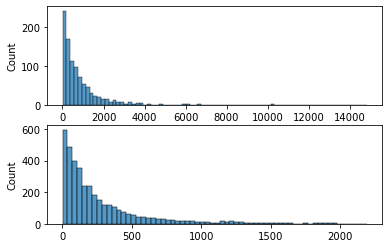

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax =plt.subplots(2,1)
sns.histplot(list(node_count.values()), ax=ax[0])
sns.histplot(list(pair_count.values()), ax=ax[1])
fig.show()